In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### EDA

In [2]:
df=pd.read_csv('train_sample.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [4]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [5]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
df.drop('attributed_time',axis=1, inplace=True)

In [7]:
df.is_attributed.value_counts(normalize=True)

0    0.99773
1    0.00227
Name: is_attributed, dtype: float64

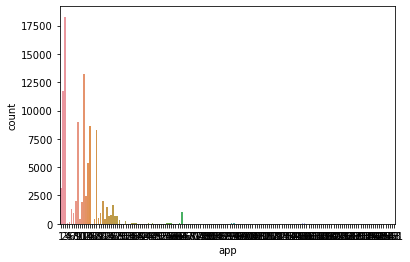

In [8]:
sns.countplot(data=df,x='app')
plt.show()

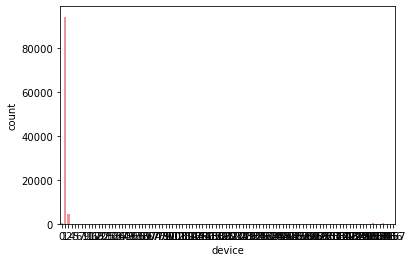

In [9]:
sns.countplot(data=df,x='device')
plt.show()

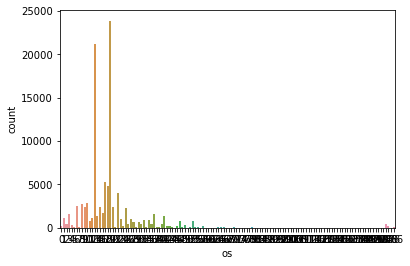

In [10]:
sns.countplot(data=df,x='os')
plt.show()

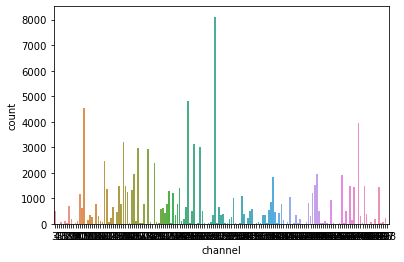

In [11]:
sns.countplot(data=df,x='channel')
plt.show()

In [12]:
df.groupby('ip')['ip'].count().reset_index(name='Count').sort_values('Count', ascending=False).head(200)

,ip,Count
926,5348,669
918,5314,616
12833,73487,439
12839,73516,399
9385,53454,280
...,...,...
23859,145934,25
6636,38219,25
9493,53960,25
14498,83280,25


In [13]:
df['click_time']=pd.to_datetime(df['click_time'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ip             100000 non-null  int64         
 1   app            100000 non-null  int64         
 2   device         100000 non-null  int64         
 3   os             100000 non-null  int64         
 4   channel        100000 non-null  int64         
 5   click_time     100000 non-null  datetime64[ns]
 6   is_attributed  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 5.3 MB


In [15]:
df[['click_time']].head()

,click_time
0,2017-11-07 09:30:38
1,2017-11-07 13:40:27
2,2017-11-07 18:05:24
3,2017-11-07 04:58:08
4,2017-11-09 09:00:09


### Feature Engineering

In [16]:
# df['day']
df['day_of_week']= df['click_time'].dt.dayofweek
df['hour']= df['click_time'].dt.hour
df['month']=df['click_time'].dt.month
# df['click_time'].dt.year
df['day_of_year'] =df['click_time'].dt.dayofyear

In [17]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed,day_of_week,hour,month,day_of_year
0,87540,12,1,13,497,2017-11-07 09:30:38,0,1,9,11,311
1,105560,25,1,17,259,2017-11-07 13:40:27,0,1,13,11,311
2,101424,12,1,19,212,2017-11-07 18:05:24,0,1,18,11,311
3,94584,13,1,13,477,2017-11-07 04:58:08,0,1,4,11,311
4,68413,12,1,1,178,2017-11-09 09:00:09,0,3,9,11,313


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ip             100000 non-null  int64         
 1   app            100000 non-null  int64         
 2   device         100000 non-null  int64         
 3   os             100000 non-null  int64         
 4   channel        100000 non-null  int64         
 5   click_time     100000 non-null  datetime64[ns]
 6   is_attributed  100000 non-null  int64         
 7   day_of_week    100000 non-null  int64         
 8   hour           100000 non-null  int64         
 9   month          100000 non-null  int64         
 10  day_of_year    100000 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 8.4 MB


In [19]:
df.drop('click_time',axis=1,inplace=True)

In [20]:
(df.memory_usage()/1024**2).sum()

7.6295166015625

In [21]:
ip_count= df.groupby('ip').size().rename('ip_count').reset_index()

In [22]:
ip_day_hour=df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour')

In [23]:
ip_hour_channel= df.groupby(['ip','channel','hour']).size().reset_index(name='ip_hour_channel')

In [24]:
ip_hour_os= df.groupby(['ip','os','hour']).size().reset_index(name='ip_hour_os')

In [25]:
ip_hour_app= df.groupby(['ip','app','hour']).size().reset_index(name='ip_hour_app')

In [26]:
ip_hour_device= df.groupby(['ip','device','hour']).size().reset_index(name='ip_hour_device')

In [27]:
df= pd.merge(df,ip_count, how='left', on ='ip')


In [28]:
df=pd.merge(df,ip_day_hour, how='left', on =['ip', 'day_of_week', 'hour'])
df=pd.merge(df,ip_hour_channel, how='left', on =['ip','channel','hour'])
df=pd.merge(df,ip_hour_os, how='left', on =['ip','os','hour'])
df=pd.merge(df,ip_hour_app, how='left', on =['ip','app','hour'])
df=pd.merge(df,ip_hour_device, how='left', on =['ip','device','hour'])

In [29]:
df.head()

,ip,app,device,os,channel,is_attributed,day_of_week,hour,month,day_of_year,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,87540,12,1,13,497,0,1,9,11,311,8,1,1,1,1,1
1,105560,25,1,17,259,0,1,13,11,311,149,4,1,1,1,8
2,101424,12,1,19,212,0,1,18,11,311,2,1,1,1,1,1
3,94584,13,1,13,477,0,1,4,11,311,3,1,1,1,1,1
4,68413,12,1,1,178,0,3,9,11,313,4,1,1,1,1,1


#### Split Data

In [30]:
# create x and y train
X = df.drop('is_attributed', axis=1)
y = df[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [31]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


## Modelling

#### AdaBoost

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
# Getting Base model

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
metrics.roc_auc_score(y_test, ada.predict_proba(X_test)[:,1])

0.9635813914641276

In [34]:
## Perform HyperTunning

param_grid = {
    'n_estimators' : [20.50,100,300,400,500,600],
    'learning_rate': [0.01,0.05,0.09,0.1,0.5,1.0]
    
}

ada = AdaBoostClassifier()

ada_grid_cv = GridSearchCV(ada, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=True, scoring='roc_auc')

In [35]:
%%time
ada_grid_cv.fit(X_train,y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Wall time: 6min 43s


GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.09, 0.1, 0.5, 1.0],
                         'n_estimators': [20.5, 100, 300, 400, 500, 600]},
             return_train_score=True, scoring='roc_auc', verbose=True)

In [36]:
ada_df= pd.DataFrame(ada_grid_cv.cv_results_)[['rank_test_score','param_n_estimators','param_learning_rate',
                                       'mean_train_score','mean_test_score']]

In [37]:
# ada_df.groupby('param_learning_rate')[ 'mean_train_score','mean_test_score'].mean().plot()

<AxesSubplot:xlabel='param_n_estimators'>

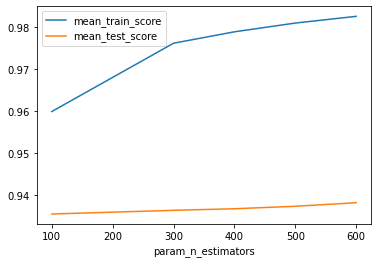

In [38]:
ada_df.groupby('param_n_estimators')[ 'mean_train_score','mean_test_score'].mean().plot()

In [39]:
ada_grid_cv.best_estimator_

AdaBoostClassifier(learning_rate=0.05, n_estimators=500)

In [40]:
ada_grid_cv.best_score_

0.9522646226563574

In [41]:
# Creating the Final model

final_ada=AdaBoostClassifier(learning_rate=0.05, n_estimators=500)
final_ada.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.05, n_estimators=500)

In [42]:
metrics.roc_auc_score(y_train, final_ada.predict_proba(X_train)[:,1])

0.9736778919294141

In [43]:
metrics.roc_auc_score(y_test, final_ada.predict_proba(X_test)[:,1])

0.9559831843870933

### Gradient Boosting

Base Model

In [44]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])

0.9610122776246552

In [45]:
## Perform HyperTunning

param_grid = {
    'n_estimators' : [50,100,150],
    'subsample' :    [0.3,0.6,0.9,1.0]
    
}

gbm = GradientBoostingClassifier()

gbm_grid_cv = GridSearchCV(gbm, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=True, scoring='roc_auc')

# Fit the model

# %%time
gbm_grid_cv.fit(X_train,y_train)


# Convert the results to a dataframe
gbm_df= pd.DataFrame(gbm_grid_cv.cv_results_)[['rank_test_score','param_subsample','param_n_estimators',
                                       'mean_train_score','mean_test_score']]

Fitting 4 folds for each of 12 candidates, totalling 48 fits


<AxesSubplot:xlabel='param_subsample'>

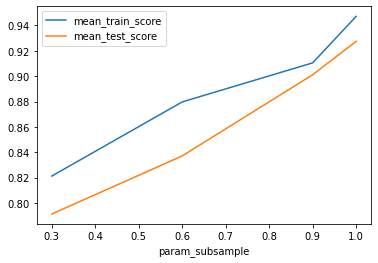

In [46]:
gbm_df.groupby('param_subsample')[ 'mean_train_score','mean_test_score'].mean().plot()

<AxesSubplot:xlabel='param_n_estimators'>

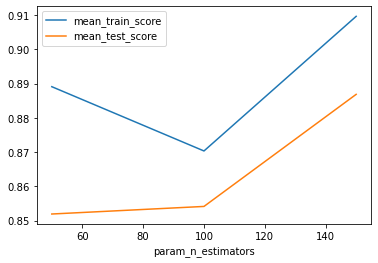

In [47]:
gbm_df.groupby('param_n_estimators')[ 'mean_train_score','mean_test_score'].mean().plot()

In [48]:
gbm_grid_cv.best_estimator_

GradientBoostingClassifier(n_estimators=150)

In [49]:
gbm_grid_cv.best_score_

0.9380061354833393

### XGBOOST

Base Model

In [51]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
metrics.roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

[09:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9732776524958935

In [52]:
## Perform HyperTunning

param_grid = {'learning_rate': [0.1,0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}    

xgb = XGBClassifier()

xgb_grid_cv = GridSearchCV(xgb, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=True, scoring='roc_auc')

# Fit the model

# %%time
xgb_grid_cv.fit(X_train,y_train)


# Convert the results to a dataframe
xgb_df= pd.DataFrame(xgb_grid_cv.cv_results_)[['rank_test_score','param_subsample','param_learning_rate',
                                       'mean_train_score','mean_test_score']]

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[09:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:xlabel='param_subsample'>

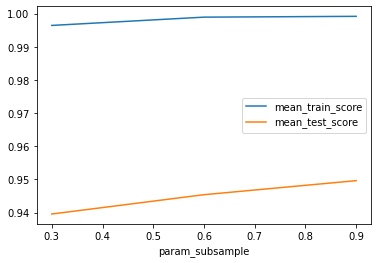

In [53]:
xgb_df.groupby('param_subsample')[ 'mean_train_score','mean_test_score'].mean().plot()

<AxesSubplot:xlabel='param_learning_rate'>

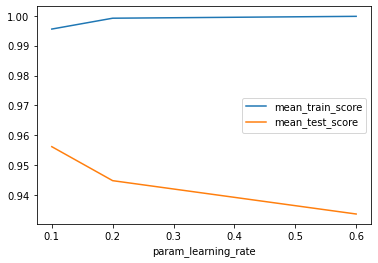

In [54]:
xgb_df.groupby('param_learning_rate')[ 'mean_train_score','mean_test_score'].mean().plot()

In [56]:
from lightgbm import LGBMClassifier

In [65]:
lgbm = LGBMClassifier(max_depth=3)
lgbm.fit(X_train,y_train)
metrics.roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])

0.9631125588128846

In [58]:
from catboost import CatBoostClassifier

In [67]:
cbm = CatBoostClassifier(max_depth=5)
cbm.fit(X_train,y_train)
metrics.roc_auc_score(y_test, cbm.predict_proba(X_test)[:,1])

Learning rate set to 0.06692
0:	learn: 0.5109828	total: 15.6ms	remaining: 15.6s
1:	learn: 0.3769000	total: 19.1ms	remaining: 9.52s
2:	learn: 0.2797580	total: 23.6ms	remaining: 7.84s
3:	learn: 0.2077444	total: 28ms	remaining: 6.98s
4:	learn: 0.1572131	total: 32.7ms	remaining: 6.5s
5:	learn: 0.1208251	total: 37.2ms	remaining: 6.17s
6:	learn: 0.0929176	total: 42.2ms	remaining: 5.99s
7:	learn: 0.0738999	total: 46.8ms	remaining: 5.8s
8:	learn: 0.0604802	total: 51.5ms	remaining: 5.67s
9:	learn: 0.0500978	total: 56.4ms	remaining: 5.58s
10:	learn: 0.0417926	total: 61.1ms	remaining: 5.5s
11:	learn: 0.0355216	total: 66.2ms	remaining: 5.45s
12:	learn: 0.0304619	total: 71.4ms	remaining: 5.42s
13:	learn: 0.0254581	total: 76.4ms	remaining: 5.38s
14:	learn: 0.0216792	total: 81.4ms	remaining: 5.35s
15:	learn: 0.0189689	total: 86.4ms	remaining: 5.31s
16:	learn: 0.0169802	total: 91.5ms	remaining: 5.29s
17:	learn: 0.0155881	total: 96.4ms	remaining: 5.26s
18:	learn: 0.0148371	total: 101ms	remaining: 5.2s


191:	learn: 0.0056505	total: 906ms	remaining: 3.81s
192:	learn: 0.0056286	total: 910ms	remaining: 3.81s
193:	learn: 0.0056258	total: 916ms	remaining: 3.8s
194:	learn: 0.0056218	total: 920ms	remaining: 3.8s
195:	learn: 0.0056001	total: 925ms	remaining: 3.79s
196:	learn: 0.0055910	total: 930ms	remaining: 3.79s
197:	learn: 0.0055856	total: 935ms	remaining: 3.79s
198:	learn: 0.0055709	total: 940ms	remaining: 3.78s
199:	learn: 0.0055686	total: 944ms	remaining: 3.78s
200:	learn: 0.0055533	total: 949ms	remaining: 3.77s
201:	learn: 0.0055508	total: 954ms	remaining: 3.77s
202:	learn: 0.0055370	total: 958ms	remaining: 3.76s
203:	learn: 0.0055287	total: 963ms	remaining: 3.76s
204:	learn: 0.0055265	total: 968ms	remaining: 3.75s
205:	learn: 0.0055243	total: 973ms	remaining: 3.75s
206:	learn: 0.0055175	total: 978ms	remaining: 3.75s
207:	learn: 0.0055152	total: 984ms	remaining: 3.74s
208:	learn: 0.0055049	total: 989ms	remaining: 3.74s
209:	learn: 0.0055021	total: 994ms	remaining: 3.74s
210:	learn: 0.

373:	learn: 0.0045061	total: 1.83s	remaining: 3.06s
374:	learn: 0.0044997	total: 1.83s	remaining: 3.06s
375:	learn: 0.0044989	total: 1.84s	remaining: 3.05s
376:	learn: 0.0044957	total: 1.84s	remaining: 3.05s
377:	learn: 0.0044866	total: 1.85s	remaining: 3.04s
378:	learn: 0.0044794	total: 1.85s	remaining: 3.04s
379:	learn: 0.0044763	total: 1.86s	remaining: 3.03s
380:	learn: 0.0044705	total: 1.86s	remaining: 3.02s
381:	learn: 0.0044624	total: 1.87s	remaining: 3.02s
382:	learn: 0.0044572	total: 1.87s	remaining: 3.02s
383:	learn: 0.0044496	total: 1.88s	remaining: 3.01s
384:	learn: 0.0044442	total: 1.88s	remaining: 3s
385:	learn: 0.0044428	total: 1.89s	remaining: 3s
386:	learn: 0.0044169	total: 1.89s	remaining: 2.99s
387:	learn: 0.0044116	total: 1.89s	remaining: 2.99s
388:	learn: 0.0044050	total: 1.9s	remaining: 2.98s
389:	learn: 0.0044001	total: 1.9s	remaining: 2.98s
390:	learn: 0.0043935	total: 1.91s	remaining: 2.97s
391:	learn: 0.0043896	total: 1.91s	remaining: 2.97s
392:	learn: 0.004385

534:	learn: 0.0036795	total: 2.56s	remaining: 2.23s
535:	learn: 0.0036780	total: 2.56s	remaining: 2.22s
536:	learn: 0.0036724	total: 2.57s	remaining: 2.22s
537:	learn: 0.0036695	total: 2.57s	remaining: 2.21s
538:	learn: 0.0036654	total: 2.58s	remaining: 2.21s
539:	learn: 0.0036623	total: 2.58s	remaining: 2.2s
540:	learn: 0.0036600	total: 2.59s	remaining: 2.2s
541:	learn: 0.0036524	total: 2.59s	remaining: 2.19s
542:	learn: 0.0036501	total: 2.6s	remaining: 2.19s
543:	learn: 0.0036441	total: 2.6s	remaining: 2.18s
544:	learn: 0.0036434	total: 2.6s	remaining: 2.17s
545:	learn: 0.0036388	total: 2.61s	remaining: 2.17s
546:	learn: 0.0036351	total: 2.61s	remaining: 2.17s
547:	learn: 0.0036332	total: 2.62s	remaining: 2.16s
548:	learn: 0.0036323	total: 2.62s	remaining: 2.15s
549:	learn: 0.0036291	total: 2.63s	remaining: 2.15s
550:	learn: 0.0036270	total: 2.63s	remaining: 2.15s
551:	learn: 0.0036240	total: 2.64s	remaining: 2.14s
552:	learn: 0.0036217	total: 2.64s	remaining: 2.13s
553:	learn: 0.003

695:	learn: 0.0030702	total: 3.29s	remaining: 1.44s
696:	learn: 0.0030677	total: 3.3s	remaining: 1.43s
697:	learn: 0.0030666	total: 3.3s	remaining: 1.43s
698:	learn: 0.0030562	total: 3.31s	remaining: 1.42s
699:	learn: 0.0030549	total: 3.31s	remaining: 1.42s
700:	learn: 0.0030527	total: 3.32s	remaining: 1.41s
701:	learn: 0.0030502	total: 3.32s	remaining: 1.41s
702:	learn: 0.0030485	total: 3.33s	remaining: 1.4s
703:	learn: 0.0030471	total: 3.33s	remaining: 1.4s
704:	learn: 0.0030466	total: 3.33s	remaining: 1.4s
705:	learn: 0.0030446	total: 3.34s	remaining: 1.39s
706:	learn: 0.0030419	total: 3.34s	remaining: 1.39s
707:	learn: 0.0030348	total: 3.35s	remaining: 1.38s
708:	learn: 0.0030290	total: 3.35s	remaining: 1.38s
709:	learn: 0.0030248	total: 3.36s	remaining: 1.37s
710:	learn: 0.0030227	total: 3.36s	remaining: 1.37s
711:	learn: 0.0030202	total: 3.37s	remaining: 1.36s
712:	learn: 0.0030171	total: 3.37s	remaining: 1.36s
713:	learn: 0.0030166	total: 3.38s	remaining: 1.35s
714:	learn: 0.003

886:	learn: 0.0025748	total: 4.21s	remaining: 536ms
887:	learn: 0.0025700	total: 4.21s	remaining: 531ms
888:	learn: 0.0025666	total: 4.22s	remaining: 527ms
889:	learn: 0.0025638	total: 4.22s	remaining: 522ms
890:	learn: 0.0025604	total: 4.23s	remaining: 517ms
891:	learn: 0.0025584	total: 4.24s	remaining: 513ms
892:	learn: 0.0025569	total: 4.24s	remaining: 508ms
893:	learn: 0.0025541	total: 4.24s	remaining: 503ms
894:	learn: 0.0025523	total: 4.25s	remaining: 499ms
895:	learn: 0.0025502	total: 4.25s	remaining: 494ms
896:	learn: 0.0025485	total: 4.26s	remaining: 489ms
897:	learn: 0.0025465	total: 4.26s	remaining: 484ms
898:	learn: 0.0025445	total: 4.27s	remaining: 479ms
899:	learn: 0.0025436	total: 4.27s	remaining: 475ms
900:	learn: 0.0025435	total: 4.28s	remaining: 470ms
901:	learn: 0.0025418	total: 4.28s	remaining: 465ms
902:	learn: 0.0025379	total: 4.28s	remaining: 460ms
903:	learn: 0.0025373	total: 4.29s	remaining: 455ms
904:	learn: 0.0025340	total: 4.29s	remaining: 451ms
905:	learn: 

0.9695603997884128